<a href="https://colab.research.google.com/github/eduvaladao/aulas_bigdata_astro_CBPF/blob/main/aula04_hubbleConstant.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src="https://farm66.staticflickr.com/65535/49055715328_092031af74_o.png"  width="150" />

<font size="5"> Calculando a constante de Hubble
    
<font size="2">
    
This solution was developed by Bernardo Fraga and Luciana Dias for the XIII Escola do CBPF - Curso de Introdução a Cosmologia com Python prof. Clécio R. Bom
<a href="www.clearnightsrthebest.com">clearnightsrthebest.com</a>
    
**Contact:** bernardo@cbpf.br</font>

<font size="2">

Please do not remove this disclaimer.</font>

In [ ]:
import numpy as np
import os
import matplotlib.pyplot as plt
#!pip install scipy
import scipy.optimize as optimization
from sklearn.linear_model import LinearRegression

# Read text data from a file and plot them.
The first step in the present work is not directly related to the statistics problem at hand, but it is quite important: you have to learn how to read in a text file. There are two you can use: hubble_low_z.dat and hubble.dat. The files are lists of supernovae with 3 facts about each: the redshift z, which for our purposes is the recession velocity divided by c (this is true only to leading order in v/c); the distance d in Mpc; and the measurement error on distance, delta-d (also in Mpc). Mpc, or megaparsecs, are the typical distance units in cosmology, equal to 3,261,560 light years.

Example adapted from: https://physics.princeton.edu//~phy209/week4/index.html



In [ ]:
!ls
if not os.path.exists("hubble.zip"):
  !wget https://clearskiesrbest.files.wordpress.com/2021/08/hubble.zip
  !unzip hubble.zip
!ls

sample_data
--2021-08-10 17:43:08--  https://clearskiesrbest.files.wordpress.com/2021/08/hubble.zip
Resolving clearskiesrbest.files.wordpress.com (clearskiesrbest.files.wordpress.com)... 192.0.72.20, 192.0.72.21
Connecting to clearskiesrbest.files.wordpress.com (clearskiesrbest.files.wordpress.com)|192.0.72.20|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1728 (1.7K) [application/zip]
Saving to: ‘hubble.zip’

hubble.zip          100%[===================>]   1.69K  --.-KB/s    in 0s      

2021-08-10 17:43:08 (28.6 MB/s) - ‘hubble.zip’ saved [1728/1728]

Archive:  hubble.zip
  inflating: hubble.txt              
  inflating: hubble_low_z.txt        
  inflating: hubble_original_data.txt  
hubble_low_z.txt  hubble_original_data.txt  hubble.txt	hubble.zip  sample_data


In [ ]:
light_speed = 299792.458

In [ ]:
# solution to reading 3-column data from a text file.
# The function reads in the columns and returns a tuple of 3
# numpy arrays.
#
# Usage is:
# z,d,e = read_hubble_data('hubble_low_z.dat')
#
# It is not very general.  Would you know what to do if the # of
# columns weren't given in advance??
#
import numpy

def read_hubble_data(filename):
    """Open a 3-column file of hubble data"""

    datafile=open(filename,'r')  # 2nd argument says open for reading

    z, d, derr = [], [], []
    for line in datafile:            # Iterating over a file goes line-by-line
        (a,b,c)=line.split()         # split() breaks text at whitespace
        z.append( float(a) )
        d.append( float(b) )
        derr.append( float(c) )

    datafile.close()                 # Close the data file
    return numpy.array(z), numpy.array(d), numpy.array(derr)



In [ ]:
z_low,d_low,derr_low = read_hubble_data('hubble_low_z.txt')
z_all,d_all,derr_all = read_hubble_data('hubble.txt')

In [ ]:
hubble_original = np.genfromtxt('hubble_original_data.txt', delimiter=',', skip_header=1, usecols=(1,2))
d_hubble = hubble_original[1:,0]
v_hubble = hubble_original[1:,1]
d_hubble_good = d_hubble[v_hubble > 0]
v_hubble_good = v_hubble[v_hubble > 0]

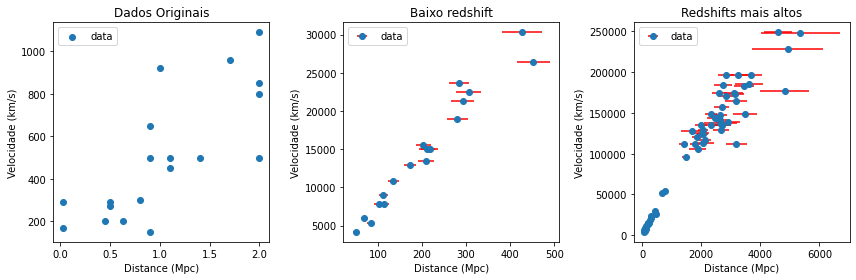

In [ ]:
# Notice three new features this week
# 1. plotting errorbars instead of just points or lines
# 2. plotting a function (any valid python or scipy expression depending on x)
# 3. drawing to a file.



f, ax = plt.subplots(nrows=1, ncols=3, figsize=[12,4])
ax[0].scatter(d_hubble_good,v_hubble_good, label="data") # Error bars. Circles at points.  No line
ax[0].set_ylabel('Velocidade (km/s)')                   # Axis title and overall title
ax[0].set_xlabel('Distance (Mpc)')              
ax[0].set_title('Dados Originais') 
#ax[0].plot(d_hubble,70*d_hubble, color='green', label="theory curve")     # Overplot a theory curve
ax[0].legend(loc='upper left')

ax[1].errorbar(d_low,z_low*light_speed,xerr=derr_low,ecolor='r', fmt='o', label="data") # Error bars. Circles at points.  No line
ax[1].set_ylabel('Velocidade (km/s)')                   # Axis title and overall title
ax[1].set_xlabel('Distance (Mpc)')              
ax[1].set_title('Baixo redshift') 
#ax[1].plot(d_low,70*d_low, color='green', label="theory curve")     # Overplot a theory curve
ax[1].legend(loc='upper left')

ax[2].errorbar(d_all,z_all*light_speed,xerr=derr_all,ecolor='r', fmt='o', label="data") # Error bars. Circles at points.  No line
ax[2].set_ylabel('Velocidade (km/s)')                   # Axis title and overall title
ax[2].set_xlabel('Distance (Mpc)')              
ax[2].set_title('Redshifts mais altos') 
#ax[2].plot(d_all,70*d_all, color='green', label="theory curve")     # Overplot a theory curve
ax[2].legend(loc='upper left')
plt.tight_layout()
plt.show()
#savefig('sample_hubble.png')

# Least-squares in Python

Example adapted from: https://python4mpia.github.io/fitting_data/least-squares-fitting.html

In [ ]:
def linear(x, a):
    return a*x

In [ ]:
# This outputs the actual parameter estimate (a, b, c) and the 3x3 covariance matrix.
# Initial guess.
x0 = numpy.array([40])
#model_original = LinearRegression(fit_intercept=False).fit(d_hubble_good.reshape(-1,1), v_hubble_good)
params_original, errors_original = optimization.curve_fit(linear, d_hubble_good, v_hubble_good, x0)
#params = np.polyfit(d_hubble_good, v_hubble_good, 1, full=True)
#print(params)
print('H0 com dados originains = {:4.2f} +- {:4.2f} km/s/Mpc'.format(params_original[0], errors_original[0,0]))
#print('H0 com dados originais = {:4.2f} km/s/Mpc'.format(model_original.coef_[0]))

H0 com dados originains = 446.47 +- 1439.00 km/s/Mpc


In [ ]:
#model_low = LinearRegression(fit_intercept=False).fit(d_low.reshape(-1,1), z_low * light_speed)
params_low, errors_low = optimization.curve_fit(linear, d_low, z_low * light_speed, x0)
print('H0 com dados de baixo redshift = {:4.2f} +- {:4.2f} km/s/Mpc'.format(params_low[0], errors_low[0,0]))

H0 com dados de baixo redshift = 69.80 +- 3.19 km/s/Mpc


In [ ]:
#model_all = LinearRegression(fit_intercept=False).fit(d_all.reshape(-1,1), z_all * light_speed)
#print('H0 com dados todos os redshift = {:4.2f} km/s/Mpc'.format(model_all.coef_[0]))
params_all, errors_all = optimization.curve_fit(linear, d_all, z_all * light_speed, x0)
print('H0 com dados de alto redshift = {:4.2f} +- {:4.2f} km/s/Mpc'.format(params_all[0], errors_all[0,0]))

NameError: ignored

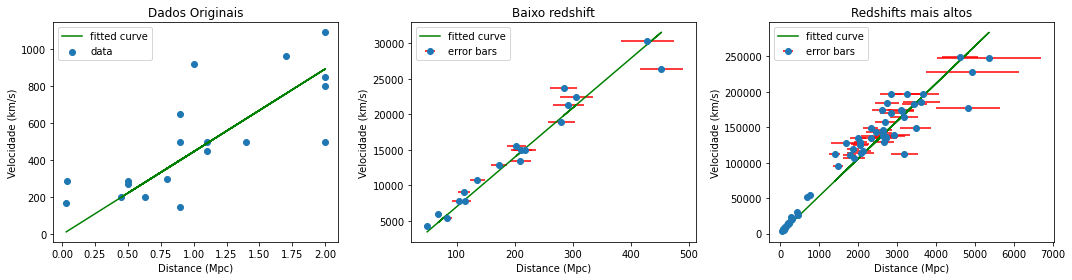

In [ ]:
f, ax = plt.subplots(nrows=1, ncols=3, figsize=[15,4])
ax[0].scatter(d_hubble_good,v_hubble_good, label="data") # Error bars. Circles at points.  No line
ax[0].set_ylabel('Velocidade (km/s)')                   # Axis title and overall title
ax[0].set_xlabel('Distance (Mpc)')              
ax[0].set_title('Dados Originais') 
ax[0].plot(d_hubble_good,params_original[0]*d_hubble_good, color='green', label="fitted curve")     # Overplot a theory curve
ax[0].legend(loc='upper left')

ax[1].errorbar(d_low,z_low*light_speed,xerr=derr_low,ecolor='r', fmt='o', label="error bars") # Error bars. Circles at points.  No line
ax[1].set_ylabel('Velocidade (km/s)')                   # Axis title and overall title
ax[1].set_xlabel('Distance (Mpc)')              
ax[1].set_title('Baixo redshift') 
ax[1].plot(d_low,params_low[0]*d_low, color='green', label="fitted curve")     # Overplot a theory curve
ax[1].legend(loc='upper left')

ax[2].errorbar(d_all,z_all*light_speed,xerr=derr_all,ecolor='r', fmt='o', label="error bars") # Error bars. Circles at points.  No line
ax[2].set_ylabel('Velocidade (km/s)')                   # Axis title and overall title
ax[2].set_xlabel('Distance (Mpc)')              
ax[2].set_title('Redshifts mais altos') 
ax[2].plot(d_all,params_all[0]*d_all, color='green', label="fitted curve")     # Overplot a theory curve
ax[2].legend(loc='upper left')
plt.tight_layout()
plt.show()